<a href="https://colab.research.google.com/github/Koks-creator/MaskDetection/blob/main/MasksVGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

# for fn in uploaded.keys():
#   print(f"User uploaded file {fn} with lengtth {uploaded[fn]} bytes.")

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 93% 307M/330M [00:06<00:00, 40.0MB/s]
100% 330M/330M [00:06<00:00, 52.9MB/s]


In [ ]:
from zipfile import ZipFile
import os, glob


file_name = "/content/face-mask-12k-images-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
!pip install keras==2.4.3 tensorflow==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 28 kB/s 
     |████████████████████████████████| 459 kB 48.3 MB/s 
     |████████████████████████████████| 2.9 MB 52.0 MB/s 
     |████████████████████████████████| 20.1 MB 1.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D, GlobalAveragePooling2D, Flatten

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [ ]:
TRAIN_DIR = r"/content/Face Mask Dataset/Train"

X = []
y = []

classes = ("WithMask", "WithoutMask")

for class_name in classes:
  for i in tqdm(os.listdir(f"{TRAIN_DIR}/{class_name}")[:1000]):
    img_path = f"{TRAIN_DIR}/{class_name}/{i}"
    try:
      img = cv2.imread(img_path)
      img = cv2.resize(img, (224, 224))
      X.append(img)
      y.append(class_name)
    except Exception as e:
      print(e)
      print(f"Nie zadzialal: {i}")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
y.count("WithMask")

1000

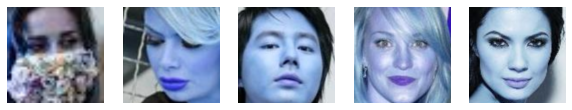

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(X[-i], cmap="gray")
  plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


In [ ]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
from keras.applications import vgg16

IMG_H, IMG_W = 224, 224

vgg = vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape = (IMG_H, IMG_W, 3)
)

for layer in vgg.layers:
  layer.trainable = False

for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def create_bottom_layers(bottom_model, classes_num: int):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation="relu")(top_model)
  top_model = Dense(1024, activation="relu")(top_model)
  top_model = Dense(512, activation="relu")(top_model)
  top_model = Dense(classes_num, activation="softmax")(top_model)

  return top_model

In [ ]:
from keras.models import Model

NUM_CLASSES = 2

fc_head = create_bottom_layers(vgg, NUM_CLASSES)
model = Model(inputs = vgg.input, outputs = fc_head)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=3, 
                    validation_data=(X_test, y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/3
50/50 [==============================] - 753s 15s/step - loss: 0.4776 - accuracy: 0.9531 - val_loss: 0.0060 - val_accuracy: 0.9975
Epoch 2/3
50/50 [==============================] - 755s 15s/step - loss: 0.0054 - accuracy: 0.9975 - val_loss: 0.0752 - val_accuracy: 0.9850
Epoch 3/3
50/50 [==============================] - 760s 15s/step - loss: 0.0168 - accuracy: 0.9950 - val_loss: 0.0086 - val_accuracy: 0.9950


In [ ]:
classes = ["mask", "nomask"]

images = []
for image_name in os.listdir("/content/Face Mask Dataset/Validation/WithoutMask")[:50]:
    # print(image_name)
    if "png" in image_name:
      img = cv2.imread(r"/content/Face Mask Dataset/Validation/WithoutMask/" + image_name)
      img = cv2.resize(img, (224, 224))

      data = np.array([img])
      pred = model.predict(data)

      label = np.argmax(pred)
      print(f"{image_name}: {classes[label]}")

      cv2.putText(img, f"Class: {classes[label]}", (5, 25), cv2.FONT_HERSHEY_PLAIN, 2, (200, 20, 50), 2)
      images.append(img)
      # cv2.imshow(image_name, img)
      # cv2.waitKey(0)


1162.png: nomask
2453.png: nomask
3358.png: nomask
3239.png: nomask
2278.png: nomask
1360.png: nomask
226.png: nomask
1229.png: nomask
2325.png: nomask
97.png: nomask
2720.png: nomask
151.png: nomask
1628.png: nomask
4624.png: nomask
5258.png: nomask
4807.png: nomask
2682.png: nomask
1016.png: nomask
5338.png: nomask
1599.png: nomask
1370.png: nomask
5853.png: nomask
4768.png: nomask
1358.png: nomask
5300.png: nomask
2244.png: nomask
2872.png: nomask
4230.png: nomask
3198.png: nomask
2282.png: nomask
1759.png: nomask
2046.png: nomask
3365.png: nomask
5658.png: nomask
3199.png: nomask
2245.png: nomask
93.png: nomask
5700.png: nomask
357.png: nomask
186.png: nomask
5314.png: nomask
4142.png: nomask
4591.png: nomask
1364.png: nomask
5248.png: nomask
2709.png: nomask
4803.png: nomask
541.png: nomask
4032.png: nomask
1956.png: nomask


In [ ]:
model.save("MaskModelVGG.h5")